# Capstone Part 2a: LSTM Base Model

Preface: Modelling was done on Colab, so there are a few lines of code that are useful only on Colab.

We will now create a character based LSTM model using the original uncleaned corpus as the database.

Note: To use this notebook, run the import cells as well as the functions cells, then go straight to the 'Results' tab.

Abstract: The model uses the basic LSTM theory and applies it to a character-wise recurrent neural network in PyTorch. The unique characters are encoded into vectors using 1-of-k encoding (similar to one-hot), and returns an output vector of the probability of each character being the next character in the sequence given the previous few characters which is then decoded into a proper character.

Reference: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [2]:
# system imports
import os
import re

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# pytorch imports
import torch
from torch import nn
import torch.nn.functional as F

# misc imports
from tqdm import tqdm
from IPython import display # for real time modelling progress update

In [79]:
print(torch.__version__)

1.7.1+cpu


In [2]:
torch.cuda.is_available() # test if colab gpu is online

False

In [4]:
df = pd.read_csv('dataset/enron6.csv')

### Functions Used

In [3]:
def get_chars(path):
    with open(path, 'r') as f: # open text file and read
        data = f.read()

    chars = list(set(data)) # return unique characters
    return chars

In [4]:
def load_data(path, chars=None):
    with open(path, 'r') as f: 
        data = f.read()

    if chars is None:
        chars = tuple(set(data)) 
    
    int2char = dict(enumerate(chars)) # create dict that num labels every unique character
    char2int = {ch: ii for ii, ch in int2char.items()} # reverse key and value for int2char dict
    
    encoded = np.array([char2int[ch] for ch in data]) # encodes characters in data into num values

    return chars, encoded

In [5]:
def one_hot_encode(arr, n_labels):
    # create matrices for each value in array with n_labels number of 0s
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)

    # populate the matrix with ones at indices specified by values of array
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.

    # reshape it to get back to the size of original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot

In [6]:
def get_batches(arr, n_seqs, n_steps):
    batch_size = n_seqs * n_steps 
    n_batches = len(arr) // batch_size 

    # ensure that batches created are always full size 
    # as slices of original array might leave a "remainder"
    arr = arr[:n_batches * batch_size] 
    
    arr = arr.reshape((n_seqs, -1)) # reshape input array to fit max batch size
    
    for n in range(0, arr.shape[1], n_steps):
        # features (sequence of characters) 
        x = arr[:, n:n + n_steps]
        
        # targets (the next character after the sequence)
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [7]:
# model definition
class CharRNN(nn.Module):
    def __init__(self, tokens, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__() # access inheritance for superclass
        self.drop_prob = drop_prob 
        self.n_layers = n_layers # recurrent layer number (number of layers)
        self.n_hidden = n_hidden # hidden feature number (nodes)

        # encode
        self.chars = tokens 
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        self.dropout = nn.Dropout(drop_prob) # instantiate dropout layer
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers,
                            dropout=drop_prob, batch_first=True) # instantiate lstm hidden layers
        # output layer with len(self.chars) as number of output nodes
        self.fc = nn.Linear(n_hidden, len(self.chars))
 
    # forward propagation
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden) 
        x = self.dropout(x)
        x = self.fc(x)

        return x, hidden

    # make a class prediction
    def predict(self, char, hidden=None, device=torch.device('cpu'), top_k=None):
        with torch.no_grad():
            self.to(device) # define cpu or gpu to use, in this case cpu
            try:
                x = np.array([[self.char2int[char]]]) # create array of matrices
            except KeyError:
                return '', hidden

            x = one_hot_encode(x, len(self.chars)) # one hot encode array of matrices
            inputs = torch.from_numpy(x).to(device) # convert numpy array to tensor for gpu usage

            out, hidden = self.forward(inputs, hidden) # propogate input tensors

            p = F.softmax(out, dim=2).data.to('cpu') # apply softmax output function and convert to cpu usage

            if top_k is None:
                top_ch = np.arange(len(self.chars))
            else:
                p, top_ch = p.topk(top_k)
                top_ch = top_ch.numpy().squeeze()

            if top_k == 1:
                char = int(top_ch)
            else:
                p = p.numpy().squeeze()
                char = np.random.choice(top_ch, p=p / p.sum())

            return self.int2char[char], hidden

In [8]:
def save_checkpoint(net, opt, filename, train_history={}):
    checkpoint = {'n_hidden': net.n_hidden,  # required parameters to be saved
                  'n_layers': net.n_layers,
                  'state_dict': net.state_dict(),
                  'optimizer': opt.state_dict(),
                  'tokens': net.chars,
                  'train_history': train_history}

    with open(filename, 'wb') as f:
        torch.save(checkpoint, f) # save model

In [9]:
def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(                      # load required parameters
        checkpoint['tokens'], 
        n_hidden=checkpoint['n_hidden'], 
        n_layers=checkpoint['n_layers']
    )
    
    net.load_state_dict(checkpoint['state_dict'])

    return net, checkpoint

In [10]:
def load_completed(filename):
    with open(filename, 'rb') as f:
        checkpoint = torch.load(f, map_location='cpu')

    net = CharRNN(
        checkpoint['tokens'],
        n_hidden=checkpoint['n_hidden'],
        n_layers=checkpoint['n_layers']
    )
    
    net.load_state_dict(checkpoint['state_dict'])

    train_history = checkpoint['train_history']

    return net, train_history

In [11]:
def train(
    net,
    data,
    epochs=10,
    n_seqs=10,
    n_steps=50,
    lr=0.001,
    clip=5,
    val_frac=0.1,
    device=torch.device('cpu'),
    name='checkpoint',
    early_stop=True,
    plot=True
):

    net.train() # switch into training mode
    opt = torch.optim.Adam(net.parameters(), lr=lr) # initialize optimizer
    criterion = nn.CrossEntropyLoss() # initialize loss function

    # create training and validation data
    val_idx = int(len(data) * (1 - val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    net.to(device) # move neural net to GPU/CPU memory
    
    min_val_loss = 10.**10 # initialize minimal validation loss
    train_history = {'epoch': [], 'step': [], 'loss': [], 'val_loss': []}

    n_chars = len(net.chars) # get size of vocabulary
    
    # main loop over training epochs
    for e in range(epochs):
        hidden = None # rest hidden state after each epoch
        
        # loop over batches
        for x, y in get_batches(data, n_seqs, n_steps):

            # encode data and create torch-tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)
            
            # reset gradient information
            net.zero_grad()
            
            # generate network output
            output, hidden = net.forward(inputs, hidden)
            
            # compute loss
            loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
            
            # compute gradients
            loss.backward()

            # gradient clipping to prevent exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            
            # optimize
            opt.step()

            # prevent backpropagating through the entire training history
            # by detaching hidden state and cell state
            hidden = (hidden[0].detach(), hidden[1].detach())
        
        # validation step is done without tracking gradients
        with torch.no_grad():
            val_h = None
            val_losses = []
            
            for x, y in get_batches(val_data, n_seqs, n_steps):
                x = one_hot_encode(x, n_chars)
                inputs, targets = torch.from_numpy(x).to(device), torch.tensor(y, dtype=torch.long).to(device)

                output, val_h = net.forward(inputs, val_h)
                
                val_loss = criterion(output.view(n_seqs * n_steps, n_chars), targets.view(n_seqs * n_steps))
                val_losses.append(val_loss.item())
            
            # compute mean validation loss over batches
            mean_val_loss = np.mean(val_losses)
            
            # track progress
            train_history['epoch'].append(e+1)
            train_history['loss'].append(loss.item())
            train_history['val_loss'].append(mean_val_loss)
        
        if plot:
            # create live plot of training loss and validation loss
            plt.clf()
            plt.plot(train_history['loss'], lw=2, c='C0')
            plt.plot(train_history['val_loss'], lw=2, c='C1')
            plt.xlabel('epoch')
            plt.title("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss), color='k')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            # print training progress
            print("{}   Epoch: {:.0f}/{:.0f}   Loss: {:.4f}   Val Loss: {:.4f}".format(
                datetime.now().strftime('%H:%M:%S'),
                e+1, epochs,
                loss.item(),
                mean_val_loss))
        
        # save model checkpoint if validation loss has decreased
        if mean_val_loss < min_val_loss:
            save_checkpoint(net, opt, name+'.net', train_history=train_history)
            min_val_loss = mean_val_loss
        
        # if validation loss has not decreased for the last 10 epochs, stop training
        if early_stop:
            if e - np.argmin(train_history['val_loss']) > 10:
                display.clear_output()
                print('Validation loss does not decrease further, stopping training.')
                break

In [12]:
def sample_lines(net, n_lines=3, prime='import', top_k=None, device='cpu', max_len=100):
    net.to(device)
    net.eval()

    # First off, run through the prime characters
    chars = []
    h = None
    for ch in prime:
        char, h = net.predict(ch, h, device=device, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    l = 0
    for ii in range(max_len):
        char, h = net.predict(chars[-1], h, device=device, top_k=top_k)
        chars.append(char)
        if char == '\n':
            l += 1
            if l == n_lines:
                break

    return ''.join(chars)

In [13]:
def clean_string(x):
    x = re.sub('#.*$', '', x, flags=re.MULTILINE)
    x = re.sub("'''[\s\S]*?'''", '', x, flags=re.MULTILINE)
    x = re.sub('"""[\s\S]*?"""', '', x, flags=re.MULTILINE)
    x = re.sub('^[\t]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('^[ ]+\n', '', x, flags=re.MULTILINE)
    x = re.sub('\n[\n]+', '\n\n', x, flags=re.MULTILINE)
    return x

## Modelling

In [14]:
# use GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
df.columns

Index(['Unnamed: 0', 'Subject', 'content'], dtype='object')

In [34]:
df = df.loc[:, ['Subject', 'content']]

In [37]:
# df.to_csv('enron6.csv')

In [39]:
# np.savetxt(r'enron6.txt', df.values, fmt='%s')
# export as txt file

We want to work with txt files because there is no upside to having the file be in csv. Instead, we want all the text to be in a singular cellular file. This is a very basic model that does not predict based on context or sentiment.

Let's open the file and look at some samples.

In [1]:
with open('dataset/enron6.txt') as f:
    data = ''.join(f.readlines())

print(data[:300])
print('\n--------------------------------------------------------------------------------\n')
print(data[100000:100300])
print('\n--------------------------------------------------------------------------------\n')
print(data[200000:200300])

RTO Orders - Grid South, SE Trans, SPP and Entergy The Southeast RTO orders are out and have followed through with what we exp= ected from the discussion at the FERC meeting. The SPP and Entergy RTO proposals have been rejected because they fail to s= atisfy the scope and configuration requirements 

--------------------------------------------------------------------------------

traffic's boom, midst the glitter of one of the world's great cities, the islanders voted to return home -- though even getting there was tricky, as their landing dock was covered in lava. Today the colony is virtually self-sufficient in food and has a reasonably thriving economy based on crawfish a

--------------------------------------------------------------------------------

hether they= are excellent or superior or average and know that they have an opportunit= y to improve on that ranking through their own effort while also realizing = that we are continually trying to raise the bar with new hires. Th

In [38]:
# load data
chars, data = load_data('dataset/enron6.txt')

In [39]:
# create RNN 
net = CharRNN(chars, n_hidden=256, n_layers=3)

Validation loss does not decrease further, stopping training.


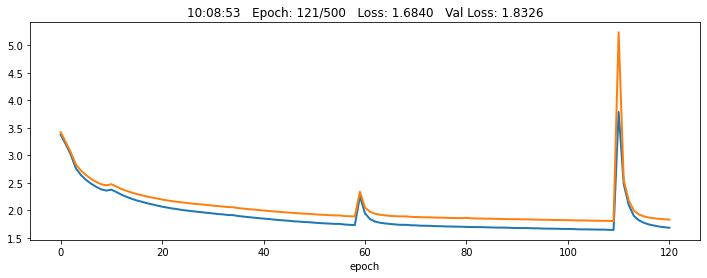

In [46]:
# train
plt.figure(figsize=(12, 4))
train(net, data, epochs=500, n_seqs=768, n_steps=512, lr=0.001, device=device, val_frac=0.1,
      name='enron6', plot=True)

## Results

In [14]:
# load model
net, _ = load_checkpoint('models/enron6.pt')

In [15]:
prime = 'For instance,'

clean_prime = clean_string(prime)
print(sample_lines(net, 1, prime=clean_prime, top_k=3))

 the contracts as a counterparties of these process of the strategic of the contract at the price on 


In [16]:
# create a new magic function to get samples with text in ipynb cell
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

@register_cell_magic
def sample(line, prime):
    clean_prime = clean_string(prime)
    print(sample_lines(net, 1, prime=clean_prime, top_k=3))

### Seeded Text Generation Test

In [27]:
%%sample
We have not been able to

seller an are and checking to a send of the payment as a server to the subject that there will be the


In [25]:
%%sample
In other words,

and when the price are a case to the compary. We would be the price of the parties of the company wer


In [30]:
%%sample
Regarding the above, changes will be made to the structure of this company

and a project issue of the support to allow the company will contact the card are any of this project


In [63]:
%%sample
We will not be able to process the following by tomorrow as

of the products of the chaice. The contact and around that this performance and are not any the strat


As we can see, coherence is not too great. However, complete words are generated, and grammatically it makes sense. A promising start. Interestingly, it gives us slightly misspelled words every so often. These misspelled words usually only have a [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) of 1 between them (eg. 'compary' vs 'company'). However, these misspelled words would then be spelled correctly when generated in other sentences.

### Topic-based Text Generation Test

In [49]:
%%sample
financial

Corporate Services Services. In the products the state of the changes of the power on the call of con


In [34]:
%%sample
meeting

Content Conformance T


It doesn't pick up the topic at all.

Let's see if it can complete partial words.

### Word Autocompletion Test

In [26]:
%%sample
Sincer

EnronOnline Project Contrict (Private Company (Capacity) (713-345-3798 Friday, May 11, 2001 Amans Com


It does not see the input as an incomplete word, but a word that is a seed. This model, even though it is built character level, is unable to autocomplete partial words.

Next, we re-feed clean data into this model to see the differences.